In [93]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from datetime import datetime
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import GOES
import xarray as xr
import datetime as datetime
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timezone   
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

import os
import shutil
from datetime import datetime, timedelta



Imagemodel: Este modelo se utiliza para extraer las caracteristicas de las que contienen las etiquetas de tipos de nubes, (4 etiquetas en total).  VGG16 es un algoritmo de clasificación y detección utilizado para clasificar 1000 imagenes de 1000 diferentes categorías con un 92.7% de presición.

In [94]:
class ImageModel(tf.keras.Model):
    """
    Clase que contiene el modelo de redes convolucionales  encargada de extraer carácterísticas esenciales de las imagenes, en este caso
    el producto del ABI que contiene la probabilidad de existencia de nubosidad.
    
    Base_model = VGG16(...) Red neuronal preentrenada con 1000 iamgenes que contienen 1000 diferentes categorías.
    Args:
        1. weights = imagenet: el modelo se inicializará con los pesos aprendidos al entrenar VGG16 en el conjunto de datos de imagenet,
        una base de 1000 diferentes categorías. Util para clasificar bordes, texturas, formas.
        2. Include_top=False: Se exluye la ultima capa la cual contiene 1000 neuronas utilizadas para clasificar de acuerdo con el dataset
        de imagenes contenido en el dataset de imagenet. Solo se usa este modelo para extraer patrones e información importante.
        3. Input_shape = (300, 300, 3): Por rendimiento, logré utilizar imagenes de resolución de 300x300 con 3 canales referidos al RGB.
    
    Extracción de características:self.feature_extractor = Model(..)
    extraer la salida de la red neuronal y transformarla en un vector unidimensional.
    Args:
        1. inputs=base_model.input: entrada de la red convolucional VGG16.
        2. outputs=Flatten()(base_model.output): Salida de la red convolusional. Función flatten() para convertir en unidimencsional.
    
    Definición del flujo de datos: def call(...), se usa para llamar al modelo. En este caso cree el modelo base_model y lo llamo con el
    parámetro inputs, que serán las imagenes.
    return self.feature_extractor(inputs): la entrada son la imagenes y retorna el vector unitario con las características.
    """
    def __init__(self):
        super(ImageModel, self).__init__()
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
        self.feature_extractor = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))
    
    def call(self, inputs):
        # Extraer las características de las imágenes
        return self.feature_extractor(inputs)


class NumericalModel(tf.keras.Model):
    """
    Esta clase contiene un modelo para entrenas datos numéricos.
        1. tf.keras.sequential(): Las capas iran conectadas de manera secuencial.
        2. tf.keras.layers.Dense(128, activation='relu'): Capa totalmente conectada con 128 neuronas con función de activación
        Relu.
        3. tf.keras.layers.Dense(64, activation='relu'): Capa totalmente conectada con 64 neuronas con función de activación
        Relu.
    Definición del flujo de datos: def call(...): al igual que el anterior, se recibe una secuencia de datos numericos y se 
    retorna la salida de la red neuronal.
    """
    def __init__(self, num_units_numeric=128, num_hidden_layers=2, activation='relu'):
        super(NumericalModel, self).__init__()
        layers = []

        # Crear las capas ocultas dinámicamente
        for i in range(num_hidden_layers):
            layers.append(tf.keras.layers.Dense(num_units_numeric, activation=activation))
            
            # Reducir el tamaño de las unidades en cada capa
            num_units_numeric = int(num_units_numeric / 2)

        self.fc = tf.keras.Sequential(layers)

    def call(self, inputs):
        return self.fc(inputs)

class CombinedModel(tf.keras.Model):
    """
    Objetivo: Combinar las salidas de los modelos anteriores para procesarlas de manera conjunta. Muy aspero!!
        1. self.image_model = ImageModel(...): En esta linea, llamamos la clase que contiene el modelo que procesa las imagenes. Ojo, recibe
        las imagenes y retorna el vector de 1 variable.
        2. self.numerical_model = NumericalModel(): Recibe los datos numéricos y extrae las características.

    self.fc = tf.keras.Sequential(...): Capda densa, totalmente conectada de manera secuencial por donde se pasarán lo datos combinados.
        1. tf.keras.layers.Dense(256, activation='relu'): Capa densa totalmente conectada de 256 neuronas con función de activacióN Relu.
        2. tf.keras.layers.Dense(1). Capa de salida, 1 porque es un vector numérico.

    Definición de flujo de datos:
        Se reciben los dastos numéricos y las imagenes. 
        1. image_features = self.image_model(image_inputs): Pasamos la lista de imagenes a traves del modelo VGG16.
        2. numerical_features = self.numerical_model(numerical_inputs): Pasamos la lista de números a traves del modelo numérico.
        3. combined = tf.concat([image_features, numerical_features], axis=1): Combinamos las salidas de los modelos y hacemos haga de cuenta un
        vector gigante.
        4. self.fc(combined): La entrada de la capa densa son el vector de una dimensión con todos los datos y la salida es el valor de regresión,
        utilizo (1) para predecir un valor numérico.
    """  
    def __init__(self, num_units_numeric=128, num_hidden_layers=2, activation='relu'):
        super(CombinedModel, self).__init__()
        self.image_model = ImageModel()
        self.numerical_model = NumericalModel(num_units_numeric=num_units_numeric, 
                                              num_hidden_layers=num_hidden_layers, 
                                              activation=activation
                                              )
        
        # Capa final para la regresión
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(num_units_numeric, activation=activation),
            tf.keras.layers.Dense(1)  # Capa de salida para la predicción
        ])
    
    def call(self, inputs):
        image_inputs, numerical_inputs = inputs
        image_features = self.image_model(image_inputs)
        numerical_features = self.numerical_model(numerical_inputs)
        combined = tf.concat([image_features, numerical_features], axis=1)
        return self.fc(combined)


In [95]:
# adecuar modelo para gridsearchCV

def build_combined_model(optimizer='adam', activation='relu', num_units_numeric=128, 
                         num_hidden_layers=2, dropout_rate=0.0, learning_rate=0.001):
    # Inicializar el modelo
    model = CombinedModel(num_units_numeric=num_units_numeric, 
                          num_hidden_layers=num_hidden_layers, 
                          activation=activation)

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compilar el modelo con la inicialización de kernel
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [96]:
carpeta_resultado = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/metricas_modelo'

if not os.path.exists(carpeta_resultado):
    os.makedirs(carpeta_resultado)
    print(f'Carpeta creada: {carpeta_resultado}')
else:
    print(f'La carpeta ya existe: {carpeta_resultado}')



La carpeta ya existe: C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/metricas_modelo


In [97]:
def plot_loss(history, fold, carpeta_resultado):
    """
    Función para graficar la curva de pérdida de entrenamiento y validación.
    
    Args:
    - history: El historial de entrenamiento del modelo.
    - fold: Número del fold (si estás usando cross-validation).
    - carpeta_resultado: Carpeta donde se guardará la gráfica.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')

    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Pérdida (Validación)', linestyle='--')

    plt.title(f'Curva de Pérdida por Época (Fold {fold})')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True)

    # Guardar la gráfica
    plt.savefig(f'{carpeta_resultado}/plot_loss_mejor_modelo_fold_{fold}.png')
    plt.close()






In [98]:
def plot_predictions_vs_actual(y_test, y_test_pred, fold, best_fold=None, carpeta_resultado='./resultados'):
    
    y_test_flat = y_test.flatten()
    y_pred_flat = y_test_pred.flatten()

    if not os.path.exists(carpeta_resultado):
        os.makedirs(carpeta_resultado)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(y_test_flat, label='Valores reales (Test)', color='blue', marker='o')
    plt.plot(y_pred_flat, label='Predicciones', color='red', marker='x')

    plt.title(f'Predicciones vs Valores Reales - Fold {fold}')
    plt.xlabel('Índice')
    plt.ylabel('GHI')

    if best_fold is not None and fold == best_fold:
        plt.title(f'** Mejor Fold {fold} **', fontsize=14, fontweight='bold', color='green')

    plt.legend()
    plt.grid(True)

    plt.savefig(f'{carpeta_resultado}/predicciones_vs_reales_fold_{fold}.png')

    plt.show()

    plt.close()




In [99]:
def save_best_params(mejores_porfold, best_global_params):
    df = pd.DataFrame(mejores_porfold)
    
    # Añadir los mejores hiperparámetros globales
    best_global_params['fold'] = 'global'
    df = df.append(best_global_params, ignore_index=True)
    
    df.to_csv('mejores_hiperparametros.csv', index=False)
    print("Guardado de los mejores hiperparámetros en 'mejores_hiperparametros.csv'")


In [100]:
def n_cross_val(X_images,X_numerical, y, param_grid, outer_splits=5, inner_splits=3, epochs=15):
    """
    Implementación de Nested Cross Validation para optimización de hiperparámetros.
    """
    
    cv_externa = TimeSeriesSplit(n_splits=outer_splits)
    mejores_porfold = []
    outer_scores = []
    best_model_predictions = None
    best_actual_vs_pred = None 

    fold = 1
    modelo_mejor_global = None
    mejor_mse = np.inf
    best_fold = None 

    for train_index, test_index in cv_externa.split(X_numerical):
        X_train_images, X_test_images = X_images[train_index], X_images[test_index]
        X_train_numerical, X_test_numerical = X_numerical[train_index], X_numerical[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(f"\n=== Fold {fold} ===")
        print(f"Forma de X_train_images: {X_train_images.shape}")
        print(f"Forma de X_train_numerical: {X_train_numerical.shape}")
        print(f"Forma de y_train: {y_train.shape}")

        best_params = None
        best_mse = np.inf

        # Validación cruzada interna
        cv_interna = TimeSeriesSplit(n_splits=inner_splits)

        for optimizer in param_grid['optimizer']:
            for activation in param_grid['activation']:
                for num_units_numeric in param_grid['num_units_numeric']:
                    for learning_rate in param_grid['learning_rate']:
                        for batch_size in param_grid['batch_size']:
                            for num_hidden_layers in param_grid['num_hidden_layers']:

                                internal_mse = []
                                for train_inner_idx, val_inner_idx in cv_interna.split(X_train_numerical):
                                    X_train_inner_images, X_val_inner_images = X_train_images[train_inner_idx], X_train_images[val_inner_idx]
                                    X_train_inner_numerical, X_val_inner_numerical = X_train_numerical[train_inner_idx], X_train_numerical[val_inner_idx]
                                    y_train_inner, y_val_inner = y_train[train_inner_idx], y_train[val_inner_idx]

                                    # Construir el modelo con los hiperparámetros actuales
                                    model = build_combined_model(optimizer=optimizer, 
                                                                    activation=activation,
                                                                    num_units_numeric=num_units_numeric,
                                                                    num_hidden_layers=num_hidden_layers,
                                                                    learning_rate=learning_rate)

                                    # Entrenar el modelo en el conjunto interno de entrenamiento
                                    model.fit([X_train_inner_images, X_train_inner_numerical], y_train_inner, 
                                                epochs=epochs, batch_size=batch_size, verbose=0)

                                    # Evaluar en el conjunto interno de validación
                                    y_val_pred = model.predict([X_val_inner_images, X_val_inner_numerical])
                                    mse_val = mean_squared_error(y_val_inner, y_val_pred)
                                    internal_mse.append(mse_val)

                                avg_mse_val = np.mean(internal_mse)
                                print(f"Eval: Optimizer={optimizer}, Activation={activation}, "
                                        f"Units_numeric={num_units_numeric}, "
                                        f"Learning_rate={learning_rate}, "
                                        f"Batch_size={batch_size}, "
                                        f"Layers={num_hidden_layers}, "
                                        f"MSE={avg_mse_val}")

                                # Seleccionar el mejor conjunto de hiperparámetros
                                if avg_mse_val < best_mse:
                                    best_mse = avg_mse_val
                                    best_params = {
                                        'optimizer': optimizer,
                                        'activation': activation,
                                        'num_units_numeric': num_units_numeric,
                                        'learning_rate': learning_rate,
                                        'batch_size': batch_size,
                                        'num_hidden_layers': num_hidden_layers
                                    }

        # Entrenar el modelo final con los mejores hiperparámetros
        print(f"\nBest Params for Fold {fold}: {best_params}")
        mejores_porfold.append(best_params)

        model_final = build_combined_model(optimizer=best_params['optimizer'], 
                                           activation=best_params['activation'], 
                                           num_units_numeric=best_params['num_units_numeric'],
                                           num_hidden_layers=best_params['num_hidden_layers'],
                                           learning_rate=best_params['learning_rate']
                                           )

        # Entrenar en el conjunto de entrenamiento externo completo
        history = model_final.fit([X_train_images, X_train_numerical], y_train, validation_split=0.2,epochs=epochs, batch_size=best_params['batch_size'], verbose=0)

        # Evaluar en el conjunto de prueba externo
        y_test_pred = model_final.predict([X_test_images, X_test_numerical])
        mse_test = mean_squared_error(y_test, y_test_pred)
        outer_scores.append(mse_test)

        model_final.save(f"best_model_fold_{fold}.h5")
        print(f"Guardado el modelo del Fold {fold} en 'best_model_fold_{fold}.h5'")

        if mse_test < mejor_mse:
            mejor_mse = mse_test
            modelo_mejor_global = model_final
            best_global_params = best_params
            best_fold = fold 
            modelo_mejor_global.save(f"modelo_mejor_global.h5")
            best_model_predictions = np.zeros_like(y)
            
            if len(y_test_pred.shape) == 1:
                y_test_pred = y_test_pred.reshape(-1, 1)  
            best_model_predictions[test_index] = y_test_pred  

            best_actual_vs_pred = pd.DataFrame({
                'Valores Reales': y_test.flatten(),
                'Predicciones': y_test_pred.flatten()
            })

            best_history = history

            plot_loss(best_history, best_fold, carpeta_resultado)

            print(f"Guardado el mejor modelo global en 'best_global_model.h5' con MSE: {mejor_mse}")
    

        plot_predictions_vs_actual(y_test, y_test_pred, fold, best_fold, carpeta_resultado)
        print(f"Fold {fold} - Test MSE: {mse_test}\n")
        fold += 1

    print(f"Outer Scores: {outer_scores}")
    print(f"Mejores hiperparámetros por fold: {mejores_porfold}")
    
    return outer_scores, mejores_porfold, best_model_predictions, best_actual_vs_pred


In [101]:
def plot_mse_per_fold(mse_folds):
    # Crear el gráfico de barras para los MSE por fold
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(1, len(mse_folds) + 1), mse_folds, color='skyblue')
    plt.title('MSE por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.xticks(range(1, len(mse_folds) + 1))
    plt.grid(True)

    # Agregar etiquetas de MSE en cada barra
    for bar, mse in zip(bars, mse_folds):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(mse, 4), ha='center', va='bottom')
    
    plt.savefig(f'{carpeta_resultado}/plot_mse_per_fold.png')
    plt.close()


In [102]:
import os

# Ruta de la carpeta 'abril'
ruta_prueba = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/archivos_cortados2/mayo/abril'
ruta_prueba = os.path.normpath(ruta_prueba)

if os.path.exists(ruta_prueba):
    print(f"La carpeta {ruta_prueba} existe.")
else:
    print(f"La carpeta {ruta_prueba} NO existe.")


La carpeta C:\Users\guavitaj\Documents\tesis\algoritmos\modelo_xray\archivos_cortados2\mayo\abril existe.


In [103]:
# Resolución y 3 por RGB
height, width, channels = 64, 64, 3 

In [104]:
# Obtener el número total de imágenes
direccion = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/archivos_cortados2/mayo'
 
carpeta_destino = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2'
carpeta_resultados = 'carpeta_resultados'

carpetas_seleccionadas = ['abril']
image_files = []

for folder in carpetas_seleccionadas:
    image_folder = os.path.join(direccion,folder)
    image_folder = os.path.normpath(image_folder)
    print("dirección carpeta:",image_folder)
    if os.path.exists(image_folder):
        image_files += sorted([os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.png')])
    else:
        print("carpeta inexistente")

print(f"Número total de archivos de imagen: {len(image_files)}")

dirección carpeta: C:\Users\guavitaj\Documents\tesis\algoritmos\modelo_xray\archivos_cortados2\mayo\abril
Número total de archivos de imagen: 4270


In [108]:
import os
import shutil
from datetime import datetime, timedelta

# Mapeo de los nombres de los meses en inglés a español en minúsculas
meses_esp = {
    'january': 'enero',
    'february': 'febrero',
    'march': 'marzo',
    'april': 'abril',
    'may': 'mayo',
    'june': 'junio',
    'july': 'julio',
    'august': 'agosto',
    'september': 'septiembre',
    'october': 'octubre',
    'november': 'noviembre',
    'december': 'diciembre'
}

def generar_meses_rango(fecha_inicio, fecha_fin):
    """Genera una lista de nombres de meses (en español y minúsculas) entre dos fechas."""
    meses = []
    mes_actual = fecha_inicio

    while mes_actual <= fecha_fin:
        mes_nombre_ingles = mes_actual.strftime('%B').lower()  # Nombre del mes en inglés
        mes_nombre_esp = meses_esp[mes_nombre_ingles]  # Convertir a español
        if mes_nombre_esp not in meses:
            meses.append(mes_nombre_esp)
        # Avanzar al siguiente mes
        mes_actual += timedelta(days=32)
        mes_actual = mes_actual.replace(day=1)  # Saltar al primer día del próximo mes
    
    return meses

def procesar_imagenes_por_intervalo_seis_meses(direccion, carpeta_destino, fecha_inicio_str, fecha_fin_str, hora_inicio_str='05:00', hora_fin_str='18:40'):
    # Convertir las fechas de entrada a objetos datetime
    fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y%m%d')
    fecha_fin = datetime.strptime(fecha_fin_str, '%Y%m%d')
    hora_inicio = datetime.strptime(hora_inicio_str, '%H:%M').time()
    hora_fin = datetime.strptime(hora_fin_str, '%H:%M').time()
    
    # Generar los meses que corresponden al rango de fechas proporcionado
    carpetas_seleccionadas = generar_meses_rango(fecha_inicio, fecha_fin)
    imagenes_filtradas = []
    fechas_procesadas = set()  # Conjunto para almacenar fechas ya procesadas

    print(f"Procesando imágenes de los meses: {carpetas_seleccionadas}")
    
    # Verificar si la carpeta destino existe, si no, crearla
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
        print(f'Carpeta creada: {carpeta_destino}')
    
    # Recorrer las carpetas seleccionadas y procesar las imágenes
    for folder in carpetas_seleccionadas:
        image_folder = os.path.join(direccion, folder)
        image_folder = os.path.normpath(image_folder)
        
        if os.path.exists(image_folder):
            # Obtener todas las imágenes en la carpeta
            image_files = [os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.png')]
            
            for image_path in sorted(image_files):
                nombre_imagen = os.path.basename(image_path)
                # Extraer la fecha y hora directamente después de `_s`
                try:
                    fecha_hora_str = nombre_imagen.split('_s')[1][:14]
                    fecha_hora = datetime.strptime(fecha_hora_str, '%Y%m%d%H%M%S')
                except (ValueError, IndexError):
                    print(f"Formato de fecha no coincide para {nombre_imagen}, se omitirá.")
                    continue
                
                # Verificar si la fecha y hora están en el rango
                if fecha_inicio.date() <= fecha_hora.date() <= fecha_fin.date() and hora_inicio <= fecha_hora.time() <= hora_fin:
                    fecha_solo = fecha_hora.strftime('%Y%m%d%H%M')  # Solo la fecha y hora
                    
                    # Copiar solo una imagen por cada fecha y hora única
                    if fecha_solo not in fechas_procesadas:
                        nuevo_nombre = f"{fecha_solo}.png"  # Renombrar como solo fecha y hora
                        ruta_destino = os.path.join(carpeta_destino, nuevo_nombre)
                        
                        shutil.copy(image_path, ruta_destino)
                        print(f'Imagen copiada: {nombre_imagen} -> {nuevo_nombre}')
                        imagenes_filtradas.append((ruta_destino, fecha_hora))
                        
                        fechas_procesadas.add(fecha_solo)  # Marcar esta fecha como procesada
        else:
            print(f"La carpeta {folder} no existe")

    print(f"Número total de imágenes únicas copiadas a {carpeta_destino}: {len(imagenes_filtradas)}")
    return imagenes_filtradas



In [109]:
# Ejemplo de uso
direccion = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/archivos_cortados2/mayo'
carpeta_destino = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2'

fecha_inicio_str = '20230401'  
fecha_fin_str = '20230430'   

# Llamar a la función para procesar imágenes desde enero hasta junio
imagenes_filtradas = procesar_imagenes_por_intervalo_seis_meses(direccion, carpeta_destino, fecha_inicio_str, fecha_fin_str)

Procesando imágenes de los meses: ['abril']
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230401110022.png -> 202304011100.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230401110522.png -> 202304011105.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408125020.png -> 202304081250.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408130020.png -> 202304081300.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408131020.png -> 202304081310.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408132020.png -> 202304081320.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408133020.png -> 202304081330.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408134020.png -> 202304081340.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408135020.png -> 202304081350.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408140020.png -> 202304081400.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408141020.png -> 202304081410.png
Imagen copiada: OR_ABI-L2-ACMF-M4_G16_s20230408142020.png -> 202304081420.png
Imagen copiada: OR_A

In [110]:
import importlib
import intervalos_faltantes



importlib.reload(intervalos_faltantes)

direccion = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/archivos_cortados2/mayo'
carpeta_destino = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2'

fecha_inicio_str2 = fecha_inicio_str+'-'+'000000'  
fecha_fin_str2 = fecha_fin_str + '-'+'000000'  

imagenes_faltantes, intervalos_esperados, timestamps_archivos ,imagenes_faltantez, repetidas = intervalos_faltantes.buscar_imagenes_faltantes(carpeta_destino, fecha_inicio_str2, fecha_fin_str2)


print("Imágenes faltantes (formateadas):", imagenes_faltantes)
print("Lista de imágenes reptidas:", repetidas)



intervalos: ['202304010500', '202304010510', '202304010520', '202304010530', '202304010540', '202304010550', '202304010600', '202304010610', '202304010620', '202304010630', '202304010640', '202304010650', '202304010700', '202304010710', '202304010720', '202304010730', '202304010740', '202304010750', '202304010800', '202304010810', '202304010820', '202304010830', '202304010840', '202304010850', '202304010900', '202304010910', '202304010920', '202304010930', '202304010940', '202304010950', '202304011000', '202304011010', '202304011020', '202304011030', '202304011040', '202304011050', '202304011100', '202304011110', '202304011120', '202304011130', '202304011140', '202304011150', '202304011200', '202304011210', '202304011220', '202304011230', '202304011240', '202304011250', '202304011300', '202304011310', '202304011320', '202304011330', '202304011340', '202304011350', '202304011400', '202304011410', '202304011420', '202304011430', '202304011440', '202304011450', '202304011500', '2023040115

In [111]:
print(imagenes_filtradas)
print(len(imagenes_filtradas))

[('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304011100.png', datetime.datetime(2023, 4, 1, 11, 0, 22)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304011105.png', datetime.datetime(2023, 4, 1, 11, 5, 22)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304081250.png', datetime.datetime(2023, 4, 8, 12, 50, 20)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304081300.png', datetime.datetime(2023, 4, 8, 13, 0, 20)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304081310.png', datetime.datetime(2023, 4, 8, 13, 10, 20)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304081320.png', datetime.datetime(2023, 4, 8, 13, 20, 20)), ('C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/carpeta_resultados2\\202304081330.png', datetime.datetime(2023, 4, 8, 13, 30, 20)), (

In [112]:
#Función para normalizar las imagenes. Las trato como una matriz tipo flotante y divido por 255 por RGB.
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32')
    return image

In [113]:
image_tensors  = []

for ruta_destino, fecha_hora in imagenes_filtradas:
    image_tensor = load_and_preprocess_image(ruta_destino, target_size=(64,64))
    image_tensors.append(image_tensor)

tensor_images = np.array(image_tensors)
print(f"Formato de tensor_images: {tensor_images.shape}")

Formato de tensor_images: (2413, 64, 64, 3)


In [114]:
print(imagenes_faltantez)


['202304031230', '202304031240', '202304080500', '202304080510', '202304080520', '202304080530', '202304080540', '202304080550', '202304080600', '202304080610', '202304080620', '202304080630', '202304080640', '202304080650', '202304080700', '202304080710', '202304080720', '202304080730', '202304080740', '202304080750', '202304080800', '202304080810', '202304080820', '202304080830', '202304080840', '202304080850', '202304080900', '202304080910', '202304080920', '202304080930', '202304080940', '202304080950', '202304081000', '202304081010', '202304081020', '202304081030', '202304081040', '202304081050', '202304081100', '202304081110', '202304081120', '202304081130', '202304081140', '202304081150', '202304081200', '202304081210', '202304081220', '202304081230', '202304081240']


In [115]:
"""
Procesamiento de datos numércos:
Utilizaré el las variables GHI como mi vairable a la salida y DoY Sin'&'DoY Cos' para intentar predecir la irradiancia, puedo tener 
la misma irradiancia en la mañana y en la tarde.
"""


df = pd.read_csv('DatosParaCompartir.csv')
df['t'] = pd.to_datetime(df['t'], utc=True)
df.set_index('t', inplace=True)
inicio = datetime.strptime(fecha_inicio_str + '0500', '%Y%m%d%H%M').replace(tzinfo = timezone.utc)
fin = datetime.strptime(fecha_fin_str + '1830', '%Y%m%d%H%M').replace(tzinfo = timezone.utc)
df = df[(df.index >=inicio) & (df.index<=fin)]
df = df[(df.index.time >= pd.to_datetime('05:00:00').time()) & (df.index.time <= pd.to_datetime('18:30:00').time())]

df['t_filtrar']= df.index.strftime('%Y%m%d%H%M')

fechas_imagenes = sorted(timestamps_archivos)
fechas_excel = df['t_filtrar'].tolist

quitar_fechas = imagenes_faltantez
df = df[~df['t_filtrar'].isin(quitar_fechas)]

if fechas_excel != fechas_imagenes:
    print("Las fechas no están alineadas. Se procederá a filtrar las fechas que faltan en imágenes.")
    # Filtrar el DataFrame para excluir las fechas en `quitar_fechas`
    df = df[~df['t_filtrar'].isin(quitar_fechas)]
    print("Las fechas filtradas son:",quitar_fechas)
else:
    print("Las fechas en el archivo Excel y las imágenes están alineadas y en el mismo orden.")


scaler = MinMaxScaler()

columnas = ['GHI','TempAmb','Wind Y','Wind X','DoY Sin','DoY Cos']
escalizar = ['GHI','TempAmb','Wind Y','Wind X']
df[columnas] = scaler.fit_transform(df[columnas])
df = df[columnas].reset_index()

df = df[columnas]
df.head()

Las fechas no están alineadas. Se procederá a filtrar las fechas que faltan en imágenes.
Las fechas filtradas son: ['202304031230', '202304031240', '202304080500', '202304080510', '202304080520', '202304080530', '202304080540', '202304080550', '202304080600', '202304080610', '202304080620', '202304080630', '202304080640', '202304080650', '202304080700', '202304080710', '202304080720', '202304080730', '202304080740', '202304080750', '202304080800', '202304080810', '202304080820', '202304080830', '202304080840', '202304080850', '202304080900', '202304080910', '202304080920', '202304080930', '202304080940', '202304080950', '202304081000', '202304081010', '202304081020', '202304081030', '202304081040', '202304081050', '202304081100', '202304081110', '202304081120', '202304081130', '202304081140', '202304081150', '202304081200', '202304081210', '202304081220', '202304081230', '202304081240']


,GHI,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos
0,0.000047,0.184079,0.200761,0.344600,1.0,1.0
1,0.000048,0.181532,0.130704,0.415933,1.0,1.0
2,0.000048,0.179934,0.138777,0.456433,1.0,1.0
3,0.000049,0.178359,0.202667,0.444773,1.0,1.0
4,0.000924,0.175998,0.204884,0.385872,1.0,1.0


In [116]:
# Creo las variables numericas y mi variable de salida para el modelo.
numericas = ['TempAmb','Wind Y','Wind X','DoY Sin','DoY Cos']
valores_numericos = df[numericas].values
salida = ['GHI']
y = df[salida].values



In [117]:
print(type(valores_numericos))  
print(valores_numericos.shape)  


<class 'numpy.ndarray'>
(2411, 5)


In [118]:
print(type(y))  
print(y.shape)  
print(y[:5])

<class 'numpy.ndarray'>
(2411, 1)
[[4.69202261e-05]
 [4.76335404e-05]
 [4.83468546e-05]
 [4.91394260e-05]
 [9.23979723e-04]]


In [119]:
# Verificar el número de muestras en imágenes, datos numéricos y etiquetas

print(f"Tamaño de valores_numericos: {valores_numericos.shape}")  # (492, 3)
print(f"Tamaño de y: {y.shape}")  # (492, 1)

# Asegúrate de que todos tienen el mismo número de muestras (492)
if valores_numericos.shape[0] == y.shape[0]:
    print("El número de muestras coincide en todas las entradas.")
else:
    print("El número de muestras no coincide.")


Tamaño de valores_numericos: (2411, 5)
Tamaño de y: (2411, 1)
El número de muestras coincide en todas las entradas.



=== Fold 1 ===
Forma de X_train_images: (406, 64, 64, 3)
Forma de X_train_numerical: (406, 5)
Forma de y_train: (406, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022712D83600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/s

Guardado el modelo del Fold 1 en 'best_model_fold_1.h5'
Guardado el mejor modelo global en 'best_global_model.h5' con MSE: 0.033410814110249654


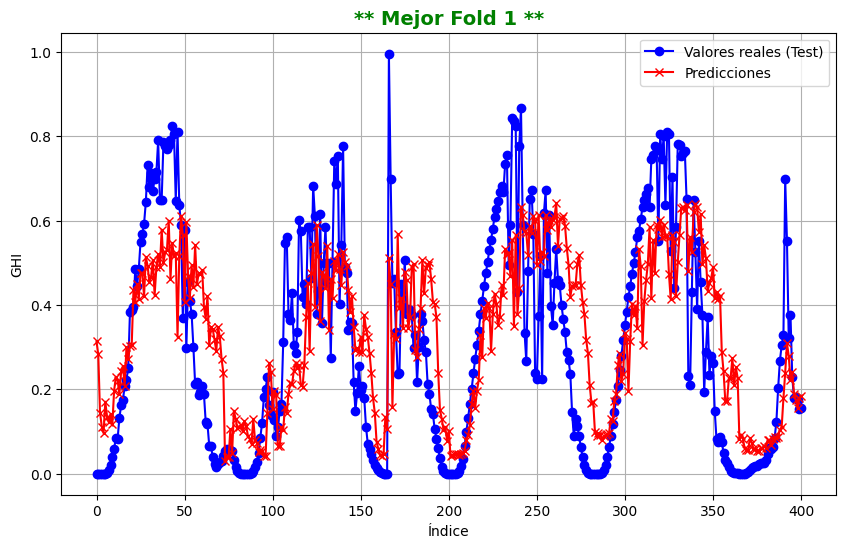

Fold 1 - Test MSE: 0.033410814110249654


=== Fold 2 ===
Forma de X_train_images: (807, 64, 64, 3)
Forma de X_train_numerical: (807, 5)
Forma de y_train: (807, 1)
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
Eval: Optimizer=adam, Activation=relu, Units_numeric=128, Learning_rate=0.001, Batch_size=16, Layers=2, MSE=0.0704559676918516

Best Params for Fold 2: {'optimizer': 'adam', 'activation': 'relu', 'num_units_numeric': 128, 'learning_rate': 0.001, 'batch_size': 16, 'num_hidden_layers': 2}


In [ ]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],               # Diferentes optimizadores
    'activation': ['relu', 'tanh'],                 # Funciones de activación para las capas
    'num_units_numeric': [64, 128, 256],                # Número de neuronas en la primera capa oculta
    'learning_rate': [0.001, 0.0001],         # Tasas de aprendizaje para los optimizadores
    'batch_size': [16, 32, 64],                     # Tamaño del batch para el entrenamiento
    'num_hidden_layers': [1, 2, 3]              # Número de capas ocultas en el modelo numéric
}

outer_scores, best_params_per_fold, mejores_predicciones, best_actual_vs_pred = n_cross_val(tensor_images,valores_numericos, y, param_grid, outer_splits=5, inner_splits=3)


In [ ]:
import matplotlib.pyplot as plt

# Función para graficar un rango de muestras definido por el usuario
def graficar_rango_muestras(best_actual_vs_pred, inicio, fin):
    # Asegurarse de que los índices de inicio y fin estén dentro del rango válido
    inicio = max(0, inicio)
    fin = min(fin, len(best_actual_vs_pred))

    if inicio >= fin:
        print("El índice de inicio debe ser menor que el índice de fin.")
        return

    # Crear la gráfica para el rango de muestras
    plt.figure(figsize=(10, 6))
    plt.plot(best_actual_vs_pred['Valores Reales'][inicio:fin], label='Valores Reales')
    plt.plot(best_actual_vs_pred['Predicciones'][inicio:fin], label='Predicciones', linestyle='--')

    # Ajustar el título y etiquetas
    plt.title(f'Valores Reales vs Predicciones (Muestras desde {inicio} hasta {fin})')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()

    # Mostrar la gráfica
    plt.show()

# Solicitar al usuario el rango de muestras a graficar
inicio_muestra = 135
fin_muestra = 310

# Llamar a la función para graficar el rango de muestras
graficar_rango_muestras(best_actual_vs_pred, inicio_muestra, fin_muestra)


